# Analyze AirBnB Data for Seattle and Boston

### Business Understanding



So you want to be an AirBnB Host?  Here are some things you should know.

So you decided to become an AirBNB host. You heard that AirBNB Superhosts can make more money than regular Hosts.  According to AirBNB, the Superhost program (also called AirBnB Plus, is offered by invitation only. AirBnB selects their AirBnB Plus hosts using the following criteria:

•	a superhost must have a 4.8+ average overall rating, 
•	10+ stays in the past year or 100 nights over at least 3 completed stays, 
•	less than 1% cancellation rate, 
•	and a 90% response rate for new messages within 24 hours
 
Using data obtained from  Inside Airbnb (http://insideairbnb.com/get-the-data.html), this author conducted an analysis, focusing on the difference between Hosts and Superhosts in Boston, Massachusetts and Seattle, Washington.

1)	What are the proportions of Hosts and Superhosts for Seattle and Boston? 

2)	How does the Superhost compare to the Host for overall rating?

3)	How do average number of stays compare for Superhosts and Hosts?

4)	How do the number of listings compare?
5)	Are Superhosts clustered into different neighborhoods than hosts?

6)	How do the daily rates compare for hosts and Superhosts?

7)	Can we use machine learning to predict which Hosts will are Superhosts?

8)  Can we identify what factors were most important in the prediction?

As this data was not part of a randomized experiment, findings are not assumed to have causality.



### Data Understanding

The following files are found in the AirBnB data for Boston and Seattle:

Boston:
calendar.csv, listings.csv, reviews.csv

Seattle:
calendar.csv, listings.csv, reviews.csv

They were downloaded from the AirBnB site at the follwing url:  http://insideairbnb.com/get-the-data.html

I changed the name of each file by adding a "-Boston" or "-Seattle" to identify the specific data.  

In [1]:
# import the relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
# choose the style to be used in plotting
from matplotlib import style
style.use('ggplot')
# import the machine learning modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time
import timeit
import matplotlib.ticker as tick

from sklearn import metrics

In [2]:
# Change default settings to allow seeing all of the data in a table.
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
pd.set_option('display.max_colwidth', 20)

# Supress warnings
warnings.filterwarnings("ignore")

## Gather

In [3]:
# This function identifies the percentage of missing values in a dataframe

def get_missing_pct(file_name):
    
    '''
    Inputs:  Enter the dataframe name that you want to assess for missing values.
    
    Outputs:  The function will output the variable names and percentage missing.
    
    '''
    
    percent_missing_filename = file_name.isnull().sum()*100 /len(file_name)
    missing_values_filename = pd.DataFrame({'column_name': file_name.columns,
                                 'percent_missing': percent_missing_filename})
    missing_values = missing_values_filename.sort_values('percent_missing', ascending=False)
    
    return missing_values



In [4]:
# This code reads the comma separated data downloade from the AirBnB website

# Read in Seattle Data
airbnb_seattle_calendar = pd.read_csv('calendar-Seattle.csv')
airbnb_seattle_listings = pd.read_csv('listings-Seattle.csv')
airbnb_seattle_reviews = pd.read_csv('reviews-Seattle.csv')

# Read in Boston Data
airbnb_boston_calendar = pd.read_csv('calendar-Boston.csv')
airbnb_boston_listings = pd.read_csv('listings-Boston.csv')
airbnb_boston_reviews = pd.read_csv('reviews-Boston.csv')


In [5]:
# Assign the city to each of the data files
airbnb_seattle_calendar['city'] = 'Seattle'
airbnb_seattle_listings['city'] = 'Seattle'
airbnb_seattle_reviews['city'] = 'Seattle'
airbnb_boston_calendar['city'] = 'Boston'
airbnb_boston_listings['city'] = 'Boston'
airbnb_boston_reviews['city'] = 'Boston'


In [6]:
# Check the structure of each data file
print("Seattle and Boston Calendar shape: ", airbnb_seattle_calendar.shape, airbnb_boston_calendar.shape)
print("Seattle and Boston Listings shape: ", airbnb_seattle_listings.shape, airbnb_boston_listings.shape)
print("Seaattle and Boston Reviews shape: ", airbnb_seattle_reviews.shape, airbnb_boston_reviews.shape)


Seattle and Boston Calendar shape:  (1393570, 5) (1308890, 5)
Seattle and Boston Listings shape:  (3818, 92) (3585, 95)
Seaattle and Boston Reviews shape:  (84849, 7) (68275, 7)


Based on the shape of each dataset, we should be able to concatenate boston and seattle under the same datasets, reducing the 6 files to 3.

In [7]:
# Identifies the dataframes to be concatenated
frames_calendar = [airbnb_seattle_calendar,airbnb_boston_calendar ]
frames_listings = [airbnb_seattle_listings, airbnb_boston_listings]
reviews_listings =[airbnb_seattle_reviews, airbnb_boston_reviews]

# Concatenates the dataframes
calendar = pd.concat(frames_calendar)
listings = pd.concat(frames_listings)
reviews = pd.concat(reviews_listings)

## Assess

In [8]:
# Validate the shape of the merged dataframes
print("Combined Seattle and Boston merged calendars: ", calendar.shape)
print("Combined Seattle and Boston merged listings: ",listings.shape)
print("Combined Seattle and Boston merged reviews: ",reviews.shape)

Combined Seattle and Boston merged calendars:  (2702460, 5)
Combined Seattle and Boston merged listings:  (7403, 95)
Combined Seattle and Boston merged reviews:  (153124, 7)


Let's begin by looking at the calendar data files.

In [9]:
# Look at what is contained in the calendr dataframe
calendar.head()

,listing_id,date,available,price,city
0,241032,2016-01-04,t,$85.00,Seattle
1,241032,2016-01-05,t,$85.00,Seattle
2,241032,2016-01-06,f,NaN,Seattle
3,241032,2016-01-07,f,NaN,Seattle
4,241032,2016-01-08,f,NaN,Seattle


In [10]:
# look at calendar's available variable
calendar.available.value_counts()

t    1577579
f    1124881
Name: available, dtype: int64

In [11]:
# Evaluate the percent of missing values in this dataframe
get_missing_pct(calendar)

,column_name,percent_missing
price,price,41.624335
listing_id,listing_id,0.000000
date,date,0.000000
available,available,0.000000
city,city,0.000000


In [12]:
# check for missing values in calendar
calendar.isnull().sum()

listing_id          0
date                0
available           0
price         1124881
city                0
dtype: int64

In [13]:
# look at the structure of the calendar file
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2702460 entries, 0 to 1308889
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   listing_id  int64 
 1   date        object
 2   available   object
 3   price       object
 4   city        object
dtypes: int64(1), object(4)
memory usage: 123.7+ MB


In [14]:
# look at some of the data in the calendar file
calendar.groupby('listing_id')['date', 'price', 'available'].head(30)

,date,price,available
0,2016-01-04,$85.00,t
1,2016-01-05,$85.00,t
2,2016-01-06,NaN,f
3,2016-01-07,NaN,f
4,2016-01-08,NaN,f
...,...,...,...
1308550,2017-05-27,NaN,f
1308551,2017-05-26,NaN,f
1308552,2017-05-25,NaN,f
1308553,2017-05-24,NaN,f


In [15]:
# look at a detailed summary statistics for the calendar dataframe
print(calendar.describe(include='all'))
print()
print('Here are the calendar minimum values')
print(calendar.min())
print()
print('Here are the calendar maximum values')
print(calendar.max())

          listing_id        date available    price     city
count   2.702460e+06     2702460   2702460  1577579  2702460
unique           NaN         611         2     1257        2
top              NaN  2016-10-02         t  $150.00  Seattle
freq             NaN        7404   1577579    57398  1393570
mean    6.950805e+06         NaN       NaN      NaN      NaN
std     4.052440e+06         NaN       NaN      NaN      NaN
min     3.335000e+03         NaN       NaN      NaN      NaN
25%     3.865313e+06         NaN       NaN      NaN      NaN
50%     7.035369e+06         NaN       NaN      NaN      NaN
75%     9.504211e+06         NaN       NaN      NaN      NaN
max     1.493346e+07         NaN       NaN      NaN      NaN

Here are the calendar minimum values
listing_id          3335
date          2016-01-04
available              f
city              Boston
dtype: object

Here are the calendar maximum values
listing_id      14933461
date          2017-09-05
available              t
cit

There are 611 unique date values in the calendar datframe.  The earliest date is 1/4/2016 and the latest date is 9/5/2017.  The data contains two cities: Seattle and Boston.  The smallest listing id is 3335 and the largest is 14933461.  Although we see a lot of NaNs, this is because the data in that column is not a number and the statistic does not apply.

In [16]:
# checking to see if available is set to t when price is missing.
check_avail = calendar.query('available == "t"')['price']!="NaN"
check_avail.sample(10)

539227     True
720348     True
501362     True
948890     True
583570     True
1185903    True
841381     True
1119367    True
362592     True
917151     True
Name: price, dtype: bool

#### Issues with calendar 

1) "available" is abbreviated as t or f.  Change to True or False.  2) "price" has non-numeric characters and large number of missing values.  3) "calendar" is showing as an object and should be changed to datetime.  We can also consider making datetime as an index to allow for time series analysis.  4) Since availability is = t when price is NaN (meaning available can be true when price is NaN, we will set null price values to 0.

In [17]:
# examine listings dataframe
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,access,interaction,house_rules
0,241032,https://www.airb...,20160104002432,2016-01-04,Stylish Queen An...,NaN,Make your self a...,Make your self a...,none,NaN,NaN,NaN,NaN,NaN,https://a1.musca...,NaN,956883,https://www.airb...,Maija,2011-08-11,"Seattle, Washing...","I am an artist, ...",within a few hours,96%,100%,f,https://a0.musca...,https://a0.musca...,Queen Anne,3.0,3.0,"['email', 'phone...",t,t,"Gilman Dr W, Sea...",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",I...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,NaN,NaN,NaN
1,953595,https://www.airb...,20160104002432,2016-01-04,Bright & Airy Qu...,Chemically sensi...,"Beautiful, hypoa...",Chemically sensi...,none,Queen Anne is a ...,What's up with t...,Convenient bus s...,https://a0.musca...,https://a0.musca...,https://a0.musca...,https://a0.musca...,5177328,https://www.airb...,Andrea,2013-02-21,"Seattle, Washing...",Living east coas...,within an hour,98%,100%,t,https://a0.musca...,https://a0.musca...,Queen Anne,6.0,6.0,"['email', 'phone...",t,t,"7th Avenue West,...",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wi...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,NaN,NaN,NaN
2,3308979,https://www.airb...,20160104002432,2016-01-04,New Modern House...,New modern house...,Our house is mod...,New modern house...,none,Upper Queen Anne...,Our house is loc...,A bus stop is ju...,NaN,NaN,https://a2.musca...,NaN,16708587,https://www.airb...,Jill,2014-06-12,"Seattle, Washing...",i love living in...,within a few hours,67%,100%,f,https://a1.musca...,https://a1.musca...,Queen Anne,2.0,2.0,"['email', 'phone...",t,t,"West Lee Street,...",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.629724,-122.369483,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",I...",NaN,$975.00,NaN,NaN,"$1,000.00",$300.00,10,$25.00,4,30,5 weeks ago,t,1,6,17,220,2016-01-04,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15,NaN,NaN,NaN
3,7421966,https://www.airb...,20160104002432,2016-01-04,Queen An

In [18]:
# look at the data type for each variable in the listings dataframe
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7403 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                7403 non-null   int64  
 1   listing_url                       7403 non-null   object 
 2   scrape_id                         7403 non-null   int64  
 3   last_scraped                      7403 non-null   object 
 4   name                              7403 non-null   object 
 5   summary                           7083 non-null   object 
 6   space                             5777 non-null   object 
 7   description                       7403 non-null   object 
 8   experiences_offered               7403 non-null   object 
 9   neighborhood_overview             4956 non-null   object 
 10  notes                             3822 non-null   object 
 11  transit                           5179 non-null   object 
 12  thumbn

#### Issues with listings

1) Notice that the price, weekly_price, monthly_price, security_deposit, cleaning_fee, extra-people columns include the $ sign.  This will cause these variables to appear objects.  This will need to be removed and converted to float64.

2) Need to change the following columns from "t" or "f" to "True" or "False" and make boolean: host_is_superhost, host_has_profile_pic, host_identity_verified, is_location_exact, has_availability, requires_license, instant_bookable, require_guest_profile_pic, require_guest_phone_verification.

3) name, summary, space, description, neighborhood_overview, notes, transit, street, amenities, zipcode, scrape_id, and last_scraped are not needed for our analysis. They will be dropped.  License contains no data and should be dropped.

4) At first glance, a number of the variables contain missing values that will need to be evaluated.  We will address those later, during data cleaning.


In [19]:
# examine the amenities variable
listings.amenities.value_counts()

{}                                                                                                                                                                                                                                                                                                                         77
{TV,"Cable TV","Wireless Internet","Air Conditioning",Kitchen,Heating,Washer,Dryer,"translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}                                                                                                                                              15
{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Gym,"Elevator in Building","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector",Essentials,Shampoo,"24-Hour Check-in",Hangers,"Hair Dryer",Iron,"Laptop Friendly Workspace"}           14
{TV,"Cable TV","Wireless Internet","Air Condit

In [20]:
# examine the host_verifications
listings.host_verifications.value_counts()

['email', 'phone', 'reviews', 'kba']                                                       1208
['email', 'phone', 'reviews', 'jumio']                                                     1124
['email', 'phone', 'reviews']                                                               937
['email', 'phone', 'facebook', 'reviews', 'kba']                                            813
['email', 'phone', 'facebook', 'reviews', 'jumio']                                          520
['email', 'phone', 'facebook', 'reviews']                                                   255
['email', 'phone']                                                                          212
['email', 'phone', 'linkedin', 'reviews', 'jumio']                                          165
['email', 'phone', 'facebook', 'linkedin', 'reviews', 'jumio']                              164
['email', 'phone', 'google', 'reviews', 'jumio']                                            153
['email', 'phone', 'facebook', 'linkedin

1) There are a number of amentities listed in this variable.  Each row contains a set of amenities that will need to be iterated over.  The issue is similar for the host_verifications variable. These lists in these two variables will be assigned into their own columns to allow the list of amenities and host_verifications to be used in the predictive analysis.  


In [21]:
# look at the host_response_time variable values
listings.host_response_time.value_counts()

within an hour        3076
within a few hours    2186
within a day          1066
a few days or more      81
Name: host_response_time, dtype: int64

This should be converted from text to values.  For example, within an hour = 1, within a few hours = 2, within a day = 24, a few days or more = 48.  Nulls should equal 999.

In [22]:
# explore the bed_type variable
listings.bed_type.value_counts()

Real Bed         7110
Futon             125
Pull-out Sofa      78
Airbed             67
Couch              23
Name: bed_type, dtype: int64

#### Issues

There do not appear to be any issues with this variable.

In [23]:
# explore the room_type variable
listings.room_type.value_counts()

Entire home/apt    4668
Private room       2538
Shared room         197
Name: room_type, dtype: int64

#### Issues

There do not appear to be any issues with this variable

In [24]:
# explore the host_is_superhost variable
listings['host_is_superhost'].value_counts()

f    6216
t    1185
Name: host_is_superhost, dtype: int64

#### Issues

As stated previously, convert t and f to True and False

In [25]:
# identify columns with numeric values
num_columns = listings.select_dtypes(include = ['int64', 'float64']).columns
num_columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

In [26]:
# Evaluate the percent of missing values in this dataframe
get_missing_pct(listings)

,column_name,percent_missing
license,license,100.000000
square_feet,square_feet,97.933270
interaction,interaction,72.565176
access,access,71.687154
house_rules,house_rules,67.675267
monthly_price,monthly_price,67.513170
weekly_price,weekly_price,60.813184
security_deposit,security_deposit,56.666216
jurisdiction_names,jurisdiction_names,48.426314
neighbourhood_group_cleansed,neighbourhood_gr...,48.426314


#### Issues with listings file


1) date_last_scraped should be datetime.

2) host_response_time, host_response_rate, host_acceptance_rate, host_listings_count, host_total_listings_count, price, weekly_price, monthly_price, security_deposit, cleaning_fee, extra_people, calculated_host_listings_count are all showing as objects and should be converted to numbers

3) There are a number of variables in the listing file with missing values. These will need to be addressed during cleaning.

#### Missing Value Issues with listings dataframe requiring cleaning

1) drop license as it has 100% missing values

2) drop square feet as it has 97% missing values

3) drop interaction as it is mising 72% of values and is not needed for this analysis

4) access has 72% missing values

5) house_rules has 68% missing values

6) change missing monthly_price to 0

7) change missing weekly_price to 0

8) change missing security_deposit to 0

9) change missing jurisdiction_names to "unknown"

10) change neighbourhood_group_cleansed	to "unknown"

11) change missing has_availability to False

12) change misssing notes to "No notes"

13) change missing neighborhood_overview to "not entered"

14) change missing transit to "not provided"

15) change missing host_about to "not provided"

16) change missing cleaning_fee to 0

17) change missing space to "not provided"

18) change all missing review scores (review_scores_accuracy, review_scores_checkin, review_scores_location, review_scores_value, review_scores_cleanliness, review_scores_communication, review_scores_rating) to their calculated mean

19) change all missing reviews_per_month to 0 

20) change all missing host_acceptance_rate to the calculated mean

21) change all host_response_time missing values to 999

22) change all missing host response rate to mean????????

23) change all missing neighbourhood to "not identified"

24) change all missing medium_url to "missing url"

25) change all missing xl_picture_url to "missing url"

26) change all missing thumbnail_url to "missing url"

27) change all missing host_neighbourhood to "not identified"

28) change missing bathrooms to 1

29) change missing host_location to "not identified"

30) change missing bedrooms to 1

31) market can be dropped

32) change missing beds to 1

33) change missing property_type to "not identified"

34) change missing host_has_profile_pic to False

35) change missing host_name to "unknown"

36) change missing host_identity_verified to False

37) change missing host_is_superhost to False

38) change missing host_total_listings_count to 0

39) change missing host_thumbnail_url to "no url"

40) change missing host_picture_url to "no url"

In [27]:
# look at the reviews data
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,city
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy pl...,Seattle
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a grea...,Seattle
2,7202016,39820030,2015-07-26,37722850,Ian,Very spacious ap...,Seattle
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle...,Seattle
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a grea...,Seattle


In [28]:
# look at the reviews data structure
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153124 entries, 0 to 68274
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     153124 non-null  int64 
 1   id             153124 non-null  int64 
 2   date           153124 non-null  object
 3   reviewer_id    153124 non-null  int64 
 4   reviewer_name  153124 non-null  object
 5   comments       153053 non-null  object
 6   city           153124 non-null  object
dtypes: int64(3), object(4)
memory usage: 9.3+ MB


In [29]:
# Evaluate the percent of missing values in this dataframe
get_missing_pct(reviews)

,column_name,percent_missing
comments,comments,0.046368
listing_id,listing_id,0.000000
id,id,0.000000
date,date,0.000000
reviewer_id,reviewer_id,0.000000
reviewer_name,reviewer_name,0.000000
city,city,0.000000


Looking at the reviewes, we can see that only the comments have nulls.  The only thing that needs to be addressed in this dataset is to change the date from object to datetime.

## Clean

## Data Preparation

### Quality Issues

### Cleaning

We start by making a copy of the data

In [30]:
# resetting the row maximum displayed to 20
pd.options.display.max_rows = 20

In [31]:
# make a copy of the data sets so we can work on the copy
air_reviews = reviews.copy(deep=False )
air_calendar = calendar.copy(deep=False )
air_listings = listings.copy(deep=False )

### Code

Let's start by fixing the date variables.


In [32]:
# This code changes the following columns to datetime.
air_reviews['date'] = pd.to_datetime(air_reviews['date']) 
air_calendar['date'] = pd.to_datetime(air_calendar['date']) 
air_listings['first_review'] = pd.to_datetime(air_listings['first_review']) 
air_listings['last_review'] = pd.to_datetime(air_listings['last_review']) 
air_listings['last_scraped'] = pd.to_datetime(air_listings['last_scraped']) 
air_listings['calendar_last_scraped'] = pd.to_datetime(air_listings['calendar_last_scraped']) 
air_listings['host_since'] = pd.to_datetime(air_listings['host_since']) 

### Validate

In [33]:
# identify columns with numeric values
air_reviews.select_dtypes(include = ['datetime']).columns


Index(['date'], dtype='object')

In [34]:
# identify columns with numeric values
air_listings.select_dtypes(include = ['datetime']).columns

Index(['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review',
       'last_review'],
      dtype='object')

### Issue

Need to change the following columns from "t" or "f" to "True" or "False" and make boolean:
host_is_superhost, host_has_profile_pic, host_identity_verified, is_location_exact, has_availability, requires_license, 
instant_bookable, require_guest_profile_pic, require_guest_phone_verification

Also, change availability column in air_calendar to boolean

### Code

In [35]:
# use code to replace t and f with True and False
var_names = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', \
             'has_availability', 'requires_license', 'instant_bookable', 'require_guest_profile_picture',\
             'require_guest_phone_verification']

for var in var_names:
    air_listings[var].replace('t', True, inplace = True)
    air_listings[var].replace('f', False, inplace = True)
    
air_calendar['available'].replace('t', True, inplace = True)
air_calendar['available'].replace('f', False, inplace = True)


### Validate

In [36]:
# identify columns with numeric values
air_listings.select_dtypes(include = ['bool']).columns

Index(['is_location_exact', 'requires_license', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification'],
      dtype='object')

In [37]:
# identify boolean column in air_calendar
air_calendar.select_dtypes(include = ['bool']).columns

Index(['available'], dtype='object')

In [38]:
# identify columns with numeric values
numeric_columns = air_listings.select_dtypes(include = ['float']).columns
numeric_columns

Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'reviews_per_month'],
      dtype='object')

Additional code is required to change thee three items below to boolean.

In [39]:
# change the type to boolean as it did not complete in the previous code
air_listings['host_is_superhost'] = air_listings['host_is_superhost'].astype('boolean')

In [40]:
# change the type to boolean as it did not complete in the previous code
air_listings['host_has_profile_pic'] = air_listings['host_has_profile_pic'].astype('boolean')

In [41]:
# change the type to boolean as it did not complete in the previous code
air_listings['host_identity_verified'] = air_listings['host_identity_verified'].astype('boolean')

### Revalidate


In [42]:
# identify columns with numeric values
datetime_columns = air_listings.select_dtypes(include = ['bool']).columns
datetime_columns

Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'is_location_exact', 'requires_license', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification'],
      dtype='object')

We can now see that the columns were converted to boolean.

### Issue

price, weekly_price, monthly_price, security_deposit, cleaning_fee, and extra_people columns include the $ sign or ','.  This will cause these variables to appear objects.  This will need to be removed and converted to  float64.

In [43]:
# this code removes string characters from numeric data
fix_price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 
                  'extra_people','host_acceptance_rate', 'host_response_rate']
air_listings[fix_price_cols] = air_listings[fix_price_cols].replace({'\$': '', ',' : '', '\%' : ''}, regex = True)

fix_price_cols = ['price']
air_calendar[fix_price_cols] = air_calendar[fix_price_cols].replace({'\$': '', ',' : '', '\%' : ''}, regex = True)
             
for fix_price in fix_price_cols:
    air_listings[fix_price] = pd.to_numeric(air_listings[fix_price])
    air_calendar[fix_price] = pd.to_numeric(air_calendar[fix_price])

### Validate

In [44]:
# check to see the structure of the variables after removing string characters from the elements.
air_listings[['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 
              'host_acceptance_rate', 'host_response_rate']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7403 entries, 0 to 3584
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 7403 non-null   float64
 1   weekly_price          2901 non-null   object 
 2   monthly_price         2405 non-null   object 
 3   security_deposit      3208 non-null   object 
 4   cleaning_fee          5266 non-null   object 
 5   extra_people          7403 non-null   object 
 6   host_acceptance_rate  6159 non-null   object 
 7   host_response_rate    6409 non-null   object 
dtypes: float64(1), object(7)
memory usage: 520.5+ KB


These items will need to be converted from object to int64 

In [45]:
# check the structure of air_calendar
air_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2702460 entries, 0 to 1308889
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   listing_id  int64         
 1   date        datetime64[ns]
 2   available   bool          
 3   price       float64       
 4   city        object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 105.7+ MB


### Issue

Need to drop null values from the air_calendar dataframe

### Code

In [46]:
# check shape before dropping null values
air_calendar.shape

(2702460, 5)

There are 1,124,881 rows where the price is null.  We will drop the null values for the following reasons: <br> 
1) It is my interpretation the residence was not listed on that date.  Availability shows as "f" when price is null.<br>
2) I am not planning to calculate a percentage occupied rate.  Not needed for this analysis

In [47]:
# this code drops the null values
air_calendar.dropna(inplace=True)

### Validate

In [48]:
# check the shape after dropping null values
air_calendar.shape

(1577579, 5)

### Issue
minimum_nights and maximum_nights have values that exceed 365.  To resolve this, values exceeding 365 will be set to the value in availability_365 column.

In [49]:
# this code replaces values in excess of 365 with the value in the availability_365 variable
air_listings['minimum_nights'] = np.where(air_listings.minimum_nights > 365, air_listings.availability_365, air_listings.minimum_nights)
air_listings['maximum_nights'] = np.where(air_listings.maximum_nights > 365, air_listings.availability_365, air_listings.maximum_nights)

### Validate

In [50]:
# check for the replaced values
air_listings[['minimum_nights','maximum_nights','availability_365']].sort_values('minimum_nights',ascending=False).head(10)

,minimum_nights,maximum_nights,availability_365
2617,363,363,363
59,300,365,0
3475,273,364,365
1764,200,365,365
2195,90,25,25
1344,90,365,340
1243,60,365,279
1416,60,365,303
1526,60,365,335
2635,60,180,183


# Issue 

Fix missing values in the air_listings dataframe

Drop these variables as they are not needed for this analysis.

In [51]:
# drop license , square_feet, interaction, zipcode, and market as they are not needed for this analysis

variables_to_drop = ['license', 'square_feet', 'interaction', 'zipcode', 'market']

for var in variables_to_drop:
    air_listings.drop([var],axis = 1, inplace=True)  

Replace these variables with "missing" so the value is not null. 

In [52]:
# change missing access, house_rules, and neighbourhood_group_cleansed to "missing"

fill_in_missing = ['access', 'house_rules', 'neighbourhood_group_cleansed']

for miss in fill_in_missing:
    air_listings[miss] = np.where(air_listings[miss].isnull(), 'missing', air_listings[miss])

Replace these variables with today's calendar date to ensure they are not missing values.

In [53]:
# change missing host_since, first_review, and last_review to today's date

fill_in_missing = ['host_since', 'first_review', 'last_review']

for miss in fill_in_missing:
    air_listings[miss] = np.where(air_listings[miss].isnull(), pd.to_datetime('today'), air_listings[miss])

Replace the values in these variables with 0.  These are likely incomplete entries.  In any anaysis using these variables, be sure to exclude values equal to zero.

In [54]:
# change missing monthly_price, weekly_price,security_deposit, reviews_per_month, host_acceptance_rate and price to 0

fill_in_missing = ['monthly_price', 'weekly_price', 'security_deposit', 'cleaning_fee', 'host_listings_count',
                  'reviews_per_month', 'host_acceptance_rate', 'price', 'host_total_listings_count']

for miss in fill_in_missing:
    air_listings[miss] =np.where(air_listings[miss].isnull(), 0, air_listings[miss])

Replace null values with False for these boolean variables.  If they are not populated, they must logically be false.

In [55]:
# change missing has_availability, host_has_profile_pic, host_identity_verfied, and host_is_superhost to False
fill_in_missing = ['has_availability', 'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost' ]

for miss in fill_in_missing:
    air_listings[miss] =np.where(air_listings[miss].isnull(), False, air_listings[miss])


Replace missing values with "Unknown" to ensure there are no null values.

In [56]:
# change missing jurisdiction_names and host_name to "Unknown"

fill_in_missing = ['jurisdiction_names', 'host_name' ]

for miss in fill_in_missing:
    air_listings[miss] =np.where(air_listings[miss].isnull(), "Unknown", air_listings[miss])


Replace missing values with "No notes" to ensure there are no null values.

In [57]:
# change missing notes to "No notes"

air_listings['notes'] = np.where(air_listings.notes.isnull(), 'No notes', air_listings.notes)

Replace missing value with "Not provided" to ensure there are no null values.

In [58]:
# change missing summary, missing neighborhood_overview, transit, host_about, and space to "not provided"

fill_in_missing = ['summary', 'neighborhood_overview', 'transit', 'host_about', 'space']

for miss in fill_in_missing:
    air_listings[miss] =np.where(air_listings[miss].isnull(), "Not provided", air_listings[miss])

Replace missing values with mean to ensure we do not pull down the mean  of these ratings with 0 rated values.

In [59]:
# change missing review_scores_accuracy, review_scores_checkin, review_scores_location, review_scores_value, 
# review_scores_cleanliness, review_scores_communication, andreview_scores_rating to calculated mean

fill_in_missing = ['review_scores_accuracy', 'review_scores_checkin', 'review_scores_location',
                   'review_scores_value', 'review_scores_cleanliness','review_scores_communication',
                  'review_scores_rating']

for miss in fill_in_missing:
    air_listings[miss] =np.where(air_listings[miss].isnull(), air_listings[miss].mean(), air_listings[miss])  



Change these values to 9999 to show they are missing values during analysis.  Be sure to exclude them during analysis.

In [60]:
# change missing host_response_time and host_response_rate to 999

fill_in_missing = ['host_response_time', 'host_response_rate']

for miss in fill_in_missing:
    air_listings[miss] =np.where(air_listings[miss].isnull(), 9999, air_listings[miss])  



Replace missing value with "Missing url" to ensure there are no null values.

In [61]:
# change missing medium_url, xl_picture_url, thumbnail_url, host_thumbnail_url, host_picture_url to "Missing url"

fill_in_missing = ['medium_url', 'xl_picture_url', 'thumbnail_url', 'host_thumbnail_url', 'host_picture_url']

for miss in fill_in_missing:
    air_listings[miss] =np.where(air_listings[miss].isnull(), 'Missing url', air_listings[miss])  



Replace missing value with "Not identified" to ensure there are no null values.

In [62]:
# change missing neighbourhood, host_neighbourhood, host_location and property_type to "Not identified"

fill_in_missing = ['neighbourhood', 'host_neighbourhood', 'host_location','property_type']

for miss in fill_in_missing:
    air_listings[miss] =np.where(air_listings[miss].isnull(), 'Not identified', air_listings[miss])  



Replace missing values with 1.  It is unlikely there are zero bathrooms, bedrooms or beds  in a listing.  Assume there is at least 1

In [63]:
# change missing neighbourhood, host_neighbourhood, host_location and property_type to "Not identified"

fill_in_missing = ['bathrooms', 'bedrooms', 'beds' ]

for miss in fill_in_missing:
    air_listings[miss] =np.where(air_listings[miss].isnull(), 1, air_listings[miss])  



Replace missing value with "No comments" to ensure there are no null values.

In [64]:
# change price in the air_calendar file to 0 when price is missing
air_reviews['comments'] = np.where(air_reviews.comments.isnull(), 'No comments', air_reviews.comments) 

### Validate

Verify that all missing values were replaced, resulting in a value of "0.0" for each variable in the output.

In [65]:
# sets the row maximum to 200
pd.options.display.max_rows = 200
# Evaluate the percent of missing values in this dataframe
get_missing_pct(air_listings)


,column_name,percent_missing
id,id,0.0
availability_90,availability_90,0.0
availability_30,availability_30,0.0
has_availability,has_availability,0.0
calendar_updated,calendar_updated,0.0
maximum_nights,maximum_nights,0.0
minimum_nights,minimum_nights,0.0
extra_people,extra_people,0.0
guests_included,guests_included,0.0
cleaning_fee,cleaning_fee,0.0


### Validate

Verify that all missing values were replaced, resulting in a value of "0.0" for each variable in the output.

In [66]:
# Evaluate the percent of missing values in this dataframe
get_missing_pct(air_calendar)


,column_name,percent_missing
listing_id,listing_id,0.0
date,date,0.0
available,available,0.0
price,price,0.0
city,city,0.0


### Validate

Verify that all missing values were replaced, resulting in a value of "0.0" for each variable in the output.

In [67]:
# Evaluate the percent of missing values in this dataframe
get_missing_pct(air_reviews)

,column_name,percent_missing
listing_id,listing_id,0.0
id,id,0.0
date,date,0.0
reviewer_id,reviewer_id,0.0
reviewer_name,reviewer_name,0.0
comments,comments,0.0
city,city,0.0


### Issue

Change 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
       'has_availability', 'host_response_rate', 'host_response_time','host_acceptance_rate', and 'host_listings_count' to int64

In [68]:
# change host response time
air_listings['host_response_time'].replace('within an hour', 1, inplace = True)
air_listings['host_response_time'].replace('within a few hours', 2, inplace = True)
air_listings['host_response_time'].replace('within a day', 24, inplace = True)
air_listings['host_response_time'].replace('a few days or more', 48, inplace = True)
air_listings['host_response_time'].replace('Not provided', 999, inplace = True)


In [69]:
# this code removes string characteres from numeric data
fix_price_cols = ['weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
       'has_availability', 'host_response_rate', 'host_response_time','host_acceptance_rate', 'host_listings_count']

air_listings[fix_price_cols] = air_listings[fix_price_cols].replace({'\$': '', ',' : '', '\%' : ''}, regex = True)





In [70]:
# this code changes the type to int64 for the variables listed below
var_list = ['weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
       'has_availability', 'host_response_rate', 'host_response_time','host_acceptance_rate', 'host_listings_count']

for var in var_list:
    # need to convert to float first and then integer to avoid error
    air_listings[var]=air_listings[var].astype('float64')
    air_listings[var]=air_listings[var].astype('int64')





### Validate

In [71]:
# validate these columns are of type int64
air_listings.select_dtypes(include = ['int64']).columns


Index(['id', 'scrape_id', 'host_id', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'accommodates', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'calculated_host_listings_count'],
      dtype='object')

### Data Preparation

In this section, we need to alter create dummy variables for the amenities and host_verification columns.

In [72]:
# look at the data contained in amenities
air_listings.amenities.head()

0    {TV,"Cable TV",I...
1    {TV,Internet,"Wi...
2    {TV,"Cable TV",I...
3    {Internet,"Wirel...
4    {TV,"Cable TV",I...
Name: amenities, dtype: object

In [73]:
# look at the data contained in host_verifications
air_listings.host_verifications.head()

0    ['email', 'phone...
1    ['email', 'phone...
2    ['email', 'phone...
3    ['email', 'phone...
4    ['email', 'phone...
Name: host_verifications, dtype: object

In [74]:
''' 
This function takes lists of lists and outputs a list of the unique items with an associated count.

Inputs:  
column_name = the variable to be evaluated
variable_name = the variable name in quotes (the same one used in )

Output
An array containing individual features. 

'''

def get_column_name_list(column, variable_name):
    
    col_list=[]
    for col in column:
        col=col.replace('"','')
        col=col.replace('{','')
        col=col.replace('}','')
        col=col.replace('[','')
        col=col.replace(']','')        
        col=col.replace("translation missing: en.hosting_amenity_49", 'Unknown amenity')
        col=col.replace("translation missing: en.hosting_amenity_50", 'Unknown amenity')
        col_list += col.split(',')

    #Transform list into a data frame
    col_list2=pd.DataFrame(col_list) 
    
    #rename the column as variable_name
    col_list2.rename(columns={0:variable_name},inplace=True) 

    #group by category and count
    col_list2=col_list2.groupby(variable_name)[variable_name].count().sort_values(ascending=False)
    
    #Rename varible_name column as count
    col_list2.rename({variable_name:'count'},inplace=True) 

    return col_list2

In [75]:
# Use the get_column_name_list function to tally the  amenities

amenities=get_column_name_list(air_listings.amenities, 'amenities') #Total

amenities

amenities
Wireless Internet             7088
Heating                       7011
Kitchen                       6707
Essentials                    6231
Smoke Detector                6192
Dryer                         5473
Washer                        5467
Internet                      5388
TV                            5181
Shampoo                       5091
Carbon Monoxide Detector      4927
Family/Kid Friendly           3851
Fire Extinguisher             3778
Air Conditioning              3498
Cable TV                      3216
Free Parking on Premises      2998
Hangers                       2831
First Aid Kit                 2743
Hair Dryer                    2585
Laptop Friendly Workspace     2579
Iron                          2570
24-Hour Check-in              1863
Elevator in Building          1653
Buzzer/Wireless Intercom      1377
Pets live on this property    1312
Indoor Fireplace              1279
Safety Card                   1185
Unknown amenity               1025
Pets Allow

In [76]:
# create the unique_items variable used in the boolean_df function
unique_items = amenities

In [77]:
''' 
This function takes a variable  and the unique_items.keys and turns the output 
into an array containing individual features.  It also sets a bot as true or false 
depending on the presence or absence of that feature in the row currently being evaluated

Inputs:  
item_list = the variable to be evaluated
unique_item = should be written as unique_items.keys()

Output
An array containing individual features. 

'''




def boolean_df(item_lists, unique_items):
    
    #create empty dictionary
    bool_dict={}
    
    #loop through all the tags
    for i, item in enumerate(unique_items):
        
        # apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    
    # return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [78]:
# create the list of columns that are output from the dummy matrix for each amenity
dummymatrix = boolean_df(air_listings['amenities'], unique_items.keys())
collist = dummymatrix.columns.values
collist

array(['Wireless Internet', 'Heating', 'Kitchen', 'Essentials',
       'Smoke Detector', 'Dryer', 'Washer', 'Internet', 'TV', 'Shampoo',
       'Carbon Monoxide Detector', 'Family/Kid Friendly',
       'Fire Extinguisher', 'Air Conditioning', 'Cable TV',
       'Free Parking on Premises', 'Hangers', 'First Aid Kit',
       'Hair Dryer', 'Laptop Friendly Workspace', 'Iron',
       '24-Hour Check-in', 'Elevator in Building',
       'Buzzer/Wireless Intercom', 'Pets live on this property',
       'Indoor Fireplace', 'Safety Card', 'Unknown amenity',
       'Pets Allowed', 'Gym', 'Dog(s)', 'Breakfast',
       'Lock on Bedroom Door', 'Cat(s)', 'Hot Tub',
       'Wheelchair Accessible', 'Doorman', 'Suitable for Events', 'Pool',
       'Smoking Allowed', '', 'Other pet(s)', 'Free Parking on Street',
       'Paid Parking Off Premises', 'Washer / Dryer'], dtype=object)

In [79]:
# Output the matrix containing the True false for each amenity
air_listings[collist] = boolean_df(air_listings['amenities'], unique_items.keys())
air_listings[collist]

,Wireless Internet,Heating,Kitchen,Essentials,Smoke Detector,Dryer,Washer,Internet,TV,Shampoo,Carbon Monoxide Detector,Family/Kid Friendly,Fire Extinguisher,Air Conditioning,Cable TV,Free Parking on Premises,Hangers,First Aid Kit,Hair Dryer,Laptop Friendly Workspace,Iron,24-Hour Check-in,Elevator in Building,Buzzer/Wireless Intercom,Pets live on this property,Indoor Fireplace,Safety Card,Unknown amenity,Pets Allowed,Gym,Dog(s),Breakfast,Lock on Bedroom Door,Cat(s),Hot Tub,Wheelchair Accessible,Doorman,Suitable for Events,Pool,Smoking Allowed,,Other pet(s),Free Parking on Street,Paid Parking Off Premises,Washer / Dryer
0,True,True,True,False,False,True,True,True,True,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,True,True,True,True,True,True,True,True,True,False,True,True,True,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
2,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,False,False,True,True,False,False,True,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False
3,True,True,True,True,True,True,True,True,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,True,True,True,True,True,False,False,True,True,True,True,True,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,True,True,True,True,True,True,False,True,False,True,True,True,True,True,False,True,True,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
3581,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False
3582,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3583,False,False,True,True,False,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [80]:
# modify the column list to remove extra quote marks and replace True and False values with 1 and 0
collist1 = ['Wireless Internet', 'Heating', 'Kitchen', 'Essentials',
       'Smoke Detector', 'Dryer', 'Washer', 'Internet', 'TV', 'Shampoo',
       'Carbon Monoxide Detector', 'Family/Kid Friendly',
       'Fire Extinguisher', 'Air Conditioning', 'Cable TV',
       'Free Parking on Premises', 'Hangers', 'First Aid Kit',
       'Hair Dryer', 'Laptop Friendly Workspace', 'Iron',
       '24-Hour Check-in', 'Elevator in Building',
       'Buzzer/Wireless Intercom', 'Pets live on this property',
       'Indoor Fireplace', 'Safety Card', 'Unknown amenity',
       'Pets Allowed', 'Gym', 'Dog(s)', 'Breakfast',
       'Lock on Bedroom Door', 'Cat(s)', 'Hot Tub',
       'Wheelchair Accessible', 'Doorman', 'Suitable for Events', 'Pool',
       'Smoking Allowed', '', 'Other pet(s)', 'Free Parking on Street',
       'Paid Parking Off Premises', 'Washer / Dryer']

for cola in collist1:
    
    # Replace True/False with 1/0
    air_listings[cola].replace(True, 1, inplace=True)
    air_listings[cola].replace(False, 0, inplace=True)
# Replace NaN with 0
    air_listings[cola].replace('NaN', 0, inplace=True)


In [81]:
# validate the replacements for True and False were made
air_listings[['amenities', 'Wireless Internet', 'Heating', 'Kitchen', 'Essentials',
       'Smoke Detector', 'Dryer', 'Washer', 'Internet', 'TV', 'Shampoo',
       'Carbon Monoxide Detector', 'Family/Kid Friendly',
       'Fire Extinguisher', 'Air Conditioning', 'Cable TV',
       'Free Parking on Premises', 'Hangers', 'First Aid Kit',
       'Hair Dryer', 'Laptop Friendly Workspace', 'Iron',
       '24-Hour Check-in', 'Elevator in Building',
       'Buzzer/Wireless Intercom', 'Pets live on this property',
       'Indoor Fireplace', 'Safety Card', 'Unknown amenity',
       'Pets Allowed', 'Gym', 'Dog(s)', 'Breakfast',
       'Lock on Bedroom Door', 'Cat(s)', 'Hot Tub',
       'Wheelchair Accessible', 'Doorman', 'Suitable for Events', 'Pool',
       'Smoking Allowed', '', 'Other pet(s)', 'Free Parking on Street',
       'Paid Parking Off Premises', 'Washer / Dryer']].head()

,amenities,Wireless Internet,Heating,Kitchen,Essentials,Smoke Detector,Dryer,Washer,Internet,TV,Shampoo,Carbon Monoxide Detector,Family/Kid Friendly,Fire Extinguisher,Air Conditioning,Cable TV,Free Parking on Premises,Hangers,First Aid Kit,Hair Dryer,Laptop Friendly Workspace,Iron,24-Hour Check-in,Elevator in Building,Buzzer/Wireless Intercom,Pets live on this property,Indoor Fireplace,Safety Card,Unknown amenity,Pets Allowed,Gym,Dog(s),Breakfast,Lock on Bedroom Door,Cat(s),Hot Tub,Wheelchair Accessible,Doorman,Suitable for Events,Pool,Smoking Allowed,,Other pet(s),Free Parking on Street,Paid Parking Off Premises,Washer / Dryer
0,"{TV,""Cable TV"",I...",1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,"{TV,Internet,""Wi...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,"{TV,""Cable TV"",I...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,"{Internet,""Wirel...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,"{TV,""Cable TV"",I...",1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [82]:
#Get host_verifications ist using get_column_name function

host_verify=get_column_name_list(air_listings.host_verifications, 'host_verifications') 
host_verify


host_verifications
'email'              7198
 'phone'             7168
 'reviews'           6867
 'kba'               3098
 'jumio'             2727
 'facebook'          2554
 'linkedin'           975
 'google'             853
 'manual_offline'     211
'phone'               198
 'amex'               109
 'manual_online'       91
 'weibo'               16
 'sent_id'             12
 'photographer'         4
None                    2
                        2
'reviews'               1
'facebook'              1
'google'                1
Name: host_verifications, dtype: int64

In [83]:
# create the unique_items variable used in the boolean_df function
unique_items = host_verify

In [84]:
# create the list of columns that are output from the dummy matrix for each host verification
dummymatrix = boolean_df(air_listings['host_verifications'], unique_items.keys())
collist = dummymatrix.columns.values
collist

array(["'email'", " 'phone'", " 'reviews'", " 'kba'", " 'jumio'",
       " 'facebook'", " 'linkedin'", " 'google'", " 'manual_offline'",
       "'phone'", " 'amex'", " 'manual_online'", " 'weibo'", " 'sent_id'",
       " 'photographer'", 'None', '', "'reviews'", "'facebook'",
       "'google'"], dtype=object)

In [85]:
# use this code to remove the double quotes in the column list
collist2 = ['email','phone', 'reviews', 'kba','jumio',
       'facebook', 'linkedin', 'google', 'manual_offline',
       'phone', 'amex', 'manual_online', 'weibo', 'sent_id',
       'photographer', 'None', '','reviews','facebook',
       'google']

In [86]:
# crate the matrix for host verifications
air_listings[collist2] = boolean_df(air_listings['host_verifications'], unique_items.keys())
air_listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,...,Carbon Monoxide Detector,Family/Kid Friendly,Fire Extinguisher,Air Conditioning,Cable TV,Free Parking on Premises,Hangers,First Aid Kit,Hair Dryer,Laptop Friendly Workspace,Iron,24-Hour Check-in,Elevator in Building,Buzzer/Wireless Intercom,Pets live on this property,Indoor Fireplace,Safety Card,Unknown amenity,Pets Allowed,Gym,Dog(s),Breakfast,Lock on Bedroom Door,Cat(s),Hot Tub,Wheelchair Accessible,Doorman,Suitable for Events,Pool,Smoking Allowed,,Other pet(s),Free Parking on Street,Paid Parking Off Premises,Washer / Dryer,email,phone,reviews,kba,jumio,facebook,linkedin,google,manual_offline,amex,manual_online,weibo,sent_id,photographer,None
0,241032,https://www.airb...,20160104002432,2016-01-04,Stylish Queen An...,Not provided,Make your self a...,Make your self a...,none,Not provided,No notes,Not provided,Missing url,Missing url,https://a1.musca...,Missing url,956883,https://www.airb...,Maija,1313020800000000000,"Seattle, Washing...","I am an artist, ...",2,96,100,False,https://a0.musca...,https://a0.musca...,Queen Anne,3,3.0,"['email', 'phone...",True,True,"Gilman Dr W, Sea...",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,"Seattle, WA",US,United States,47.636289,-122.371025,True,Apartment,Entire home/apt,4,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,0.0,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False
1,953595,https://www.airb...,20160104002432,2016-01-04,Bright & Airy Qu...,Chemically sensi...,"Beautiful, hypoa...",Chemically sensi...,none,Queen Anne is a ...,What's up with t...,Convenient bus s...,https://a0.musca...,https://a0.musca...,https://a0.musca...,https://a0.musca...,5177328,https://www.airb...,Andrea,1361404800000000000,"Seattle, Washing...",Living east coas...,1,98,100,True,https://a0.musca...,https://a0.musca...,Queen Anne,6,6.0,"['email', 'phone...",True,True,"7th Avenue West,...",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,"Seattle, WA",US,United States,47.639123,-122.365666,True,Apartment,Entire home/apt,4,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,0.0,True,True,True,False,True,True,True,False,False,False,False,False,False,False,False
2,3308979,https://www.airb...,20160104002432,2016-01-04,New Modern House...,New modern house...,Our house is mod...,New modern house...,none,Upper Queen Anne...,Our house is loc...,A bus stop is ju...,Missing url,Missing url,https://a2.musca...,Missing url,16708587,https://www.airb...,Jill,1402531200000000000,"Seattle, Washing...",i love living in...,2,67,100,False,https://a1.musca...,https://a1.musca...,Queen Anne,2,2.0,"['email', 'phone...",True,True,"West Lee Street,...",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,"Seattle, WA",US,United States,47.629724,-122.369483,True,House,Entire home/apt,11,4.5,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,0.0,True,True,True,False,True,False,False,True,False,False,False,False,False,False,False
3,7421966,https://www.airb...,20160104002432,2016-01-04,Queen Anne Chateau,A charming apart...,Not provided,A charming apar

In [87]:
# modify the column list to remove extra quote marks and replace True and False values with 1 and 0
collist2 = ['email','phone', 'reviews', 'kba','jumio',
       'facebook', 'linkedin', 'google', 'manual_offline',
       'phone', 'amex', 'manual_online', 'weibo', 'sent_id',
       'photographer', 'None', '','reviews','facebook',
       'google']

for cola in collist2:
    
    # Replace True/False with 1/0
    air_listings[cola].replace(True, 1, inplace=True)
    air_listings[cola].replace(False, 0, inplace=True)
# Replace NaN with 0
    air_listings[cola].replace('NaN', 0, inplace=True)


In [88]:
# validate the replacements for True and False were made
air_listings[['host_verifications','email','phone', 'reviews', 'kba','jumio',
       'facebook', 'linkedin', 'google', 'manual_offline',
       'phone', 'amex', 'manual_online', 'weibo', 'sent_id',
       'photographer', 'None', '','facebook',
       'google']].head()

,host_verifications,email,phone,reviews,kba,jumio,facebook,linkedin,google,manual_offline,phone,amex,manual_online,weibo,sent_id,photographer,None,,facebook,google
0,"['email', 'phone...",1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"['email', 'phone...",1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,"['email', 'phone...",1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,"['email', 'phone...",1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,"['email', 'phone...",1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Analyze

### Exploratory Data Analysis/Data Eploration

### What are the highest rated neighborhoods in Boston and Seattle?

In [89]:
# filter the data to be used in the charts
top_rated_boston = air_listings[air_listings['city']== 'Boston']
top_rated_seattle = air_listings[air_listings['city'] == 'Seattle']

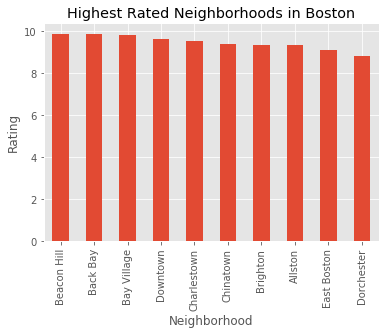

In [90]:
# exploratory bar chart of highest rated neighborhoods in Boston
top_rating_neighborhood_b = top_rated_boston.groupby(top_rated_boston['neighbourhood_cleansed'])\
                        ['review_scores_location'].mean()
top_rating_neighborhood_b[:10].sort_values(ascending=False).plot(kind='bar')
plt.title("Highest Rated Neighborhoods in Boston")
plt.xlabel('Neighborhood')
plt.ylabel('Rating')
plt.show()

In [91]:
# exploratory listing of top ten rated neighborhoods for Boston
top_rating_neighborhood_b.sort_values(ascending=False).tail(10)

neighbourhood_cleansed
South Boston    9.384363
Brighton        9.345616
Allston         9.315102
Roslindale      9.287649
Mission Hill    9.248342
Hyde Park       9.132527
East Boston     9.075019
Dorchester      8.789266
Mattapan        8.546181
Roxbury         8.517400
Name: review_scores_location, dtype: float64

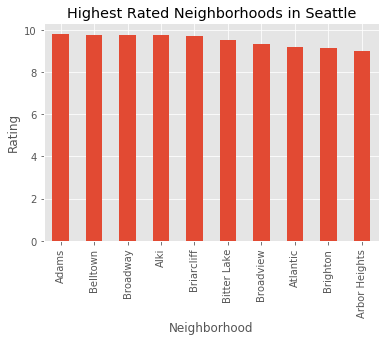

In [92]:
# exploratory bar chart of highest rated neighborhoods in Seattle
top_rating_neighborhood_s = top_rated_seattle.groupby(top_rated_seattle['neighbourhood_cleansed'])\
                            ['review_scores_location'].mean()
top_rating_neighborhood_s[:10].sort_values(ascending=False).plot(kind='bar')
plt.title("Highest Rated Neighborhoods in Seattle")
plt.xlabel('Neighborhood')
plt.ylabel('Rating')
plt.show()

In [93]:
# exploratory listing of top ten rated neighborhoods for Seattle
top_rating_neighborhood_s.sort_values(ascending=False).tail(10)

neighbourhood_cleansed
South Park             9.012037
Arbor Heights          9.007222
Industrial District    9.006019
Cedar Park             9.004514
Olympic Hills          9.002257
Dunlap                 8.879514
Holly Park             8.839352
South Beacon Hill      8.759028
Highland Park          8.639647
Pinehurst              8.500000
Name: review_scores_location, dtype: float64

### What were the highest prices per night for Seattle and Boston

In [94]:
print("Highest mean price per night for Seattle")
mean_price_neighborhood_s = top_rated_seattle.groupby(top_rated_seattle['neighbourhood_cleansed'])['price'].mean()
print(round(mean_price_neighborhood_s[:10].sort_values(ascending=False), 2))

Highest mean price per night for Seattle
neighbourhood_cleansed
Briarcliff       176.57
Alki             171.62
Belltown         162.89
Arbor Heights    126.80
Broadway         123.89
Adams            121.67
Atlantic         111.40
Broadview         94.71
Brighton          91.23
Bitter Lake       83.00
Name: price, dtype: float64


In [95]:
# identify highest mean prices for Boston
print("Highest mean price per night for Boston")
mean_price_neighborhood_b = top_rated_boston.groupby(top_rated_seattle['neighbourhood_cleansed'])['price'].mean()
print(round(mean_price_neighborhood_b[:10].sort_values(ascending=False), 2))

Highest mean price per night for Boston
neighbourhood_cleansed
Brighton         280.69
Arbor Heights    250.00
Belltown         236.03
Atlantic         214.04
Alki             209.67
Briarcliff       190.36
Bitter Lake      188.15
Adams            136.39
Bryant           104.21
Broadway          96.20
Name: price, dtype: float64


In [96]:
# join air_calendar and air_listings, merging on left using id_listing and id
airbnb_data = pd.merge(air_calendar, air_listings, left_on='listing_id', right_on='id', how='left', sort=False)
airbnb_data.head()

,listing_id,date,available,price_x,city_x,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city_y,state,smart_location,country_code,country,latitude,longitude,...,Carbon Monoxide Detector,Family/Kid Friendly,Fire Extinguisher,Air Conditioning,Cable TV,Free Parking on Premises,Hangers,First Aid Kit,Hair Dryer,Laptop Friendly Workspace,Iron,24-Hour Check-in,Elevator in Building,Buzzer/Wireless Intercom,Pets live on this property,Indoor Fireplace,Safety Card,Unknown amenity,Pets Allowed,Gym,Dog(s),Breakfast,Lock on Bedroom Door,Cat(s),Hot Tub,Wheelchair Accessible,Doorman,Suitable for Events,Pool,Smoking Allowed,,Other pet(s),Free Parking on Street,Paid Parking Off Premises,Washer / Dryer,email,phone,reviews,kba,jumio,facebook,linkedin,google,manual_offline,amex,manual_online,weibo,sent_id,photographer,None
0,241032,2016-01-04,True,85.0,Seattle,241032,https://www.airb...,20160104002432,2016-01-04,Stylish Queen An...,Not provided,Make your self a...,Make your self a...,none,Not provided,No notes,Not provided,Missing url,Missing url,https://a1.musca...,Missing url,956883,https://www.airb...,Maija,1313020800000000000,"Seattle, Washing...","I am an artist, ...",2,96,100,False,https://a0.musca...,https://a0.musca...,Queen Anne,3,3.0,"['email', 'phone...",True,True,"Gilman Dr W, Sea...",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,"Seattle, WA",US,United States,47.636289,-122.371025,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,241032,2016-01-05,True,85.0,Seattle,241032,https://www.airb...,20160104002432,2016-01-04,Stylish Queen An...,Not provided,Make your self a...,Make your self a...,none,Not provided,No notes,Not provided,Missing url,Missing url,https://a1.musca...,Missing url,956883,https://www.airb...,Maija,1313020800000000000,"Seattle, Washing...","I am an artist, ...",2,96,100,False,https://a0.musca...,https://a0.musca...,Queen Anne,3,3.0,"['email', 'phone...",True,True,"Gilman Dr W, Sea...",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,"Seattle, WA",US,United States,47.636289,-122.371025,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,241032,2016-01-13,True,85.0,Seattle,241032,https://www.airb...,20160104002432,2016-01-04,Stylish Queen An...,Not provided,Make your self a...,Make your self a...,none,Not provided,No notes,Not provided,Missing url,Missing url,https://a1.musca...,Missing url,956883,https://www.airb...,Maija,1313020800000000000,"Seattle, Washing...","I am an artist, ...",2,96,100,False,https://a0.musca...,https://a0.musca...,Queen Anne,3,3.0,"['email', 'phone...",True,True,"Gilman Dr W, Sea...",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,"Seattle, WA",US,United States,47.636289,-122.371025,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,241032,2016-01-14,True,85.0,Seattle,241032,https://www.airb...,20160104002432,2016-01-04,Stylish Queen An...,Not provided,Make your self a...,Make your self a...,none,Not provided,No notes,Not provided,Missing url,Missing url,https://a1.musca...,Missing url,956883,https://www.airb...,Maija,1313020800000000000

## Visualize

In [97]:
# create filtered datasets for Boston and Seattle where needed
boston_listings = air_listings.query('city=="Boston"')
seattle_listings = air_listings.query('city =="Seattle"')

### Question 1 - What proportion of Hosts are Superhosts for Seattle and Boston?

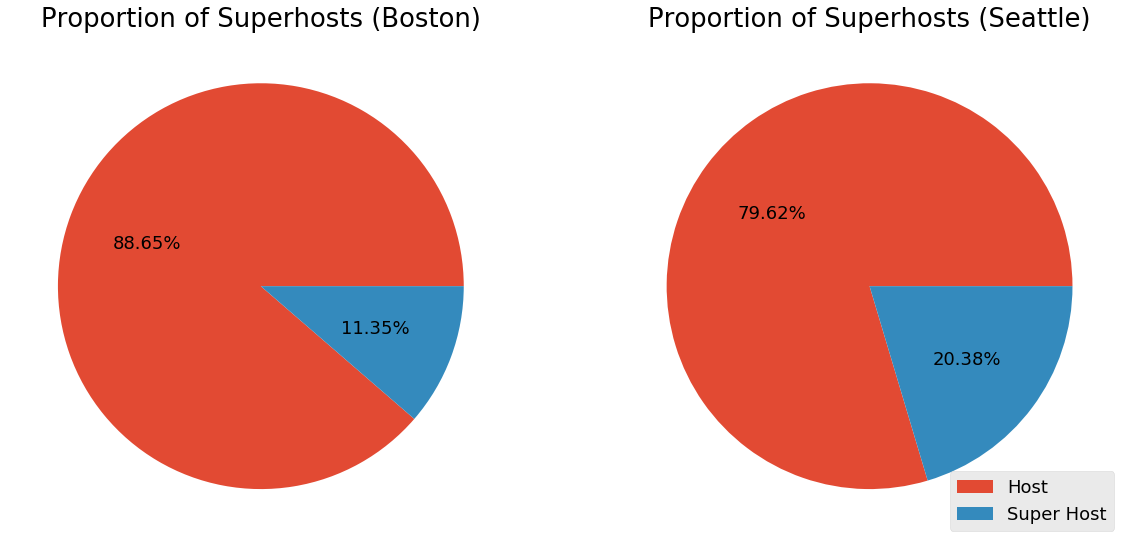

There are 3585 hosts in Boston and 3818 hosts in Seattle


In [98]:
# This section plats a pie chart of the proportion of hosts that are superhosts in Seattle and Boston

#This code creates the data sets to compare hosts and super hosts
bost_superhosts = boston_listings.groupby(boston_listings['host_is_superhost'])['host_is_superhost'].count() 
seat_superhosts = seattle_listings.groupby(seattle_listings['host_is_superhost'])['host_is_superhost'].count() 

plt.rcParams['font.size'] = 18
# This code creates the 1 row, 2 column matrix for the charts
fig,(ax0, ax1) = plt.subplots(nrows=1, ncols=2)

labels = ['Host', 'Super Host']
# This creates the first pie chart for Boston
bost_superhosts.plot.pie(y='host_is_superhost', figsize=(20, 20), labels=None,
                                autopct ="%0.2f%%", radius = 1.0, ax=ax0)
ax0.set_ylabel('')
ax0.set_title("Proportion of Superhosts (Boston)")
# This code creates teh second pie chart for Seattle
seat_superhosts.plot.pie(y='host_is_superhost', figsize=(20, 20), labels=None,
                                autopct ="%0.2f%%", radius = 1.0, ax=ax1)
ax1.set_ylabel('')
ax1.set_title("Proportion of Superhosts (Seattle)")
# This identifies where the leend will appear
plt.legend(loc='lower right', labels = labels)
plt.show()

print('There are {} hosts in Boston and {} hosts in Seattle'.format(boston_listings.host_is_superhost.count(), 
                                                                   seattle_listings.host_is_superhost.count()))


At 20%, there are twice as many superhosts in Seattle than there are in Boston.

### Question 2 - How does the Superhost compare to the Host for overall rating?

As shown in the pie charts above, Boston has almost double the proportion of Superhosts as Seattle.

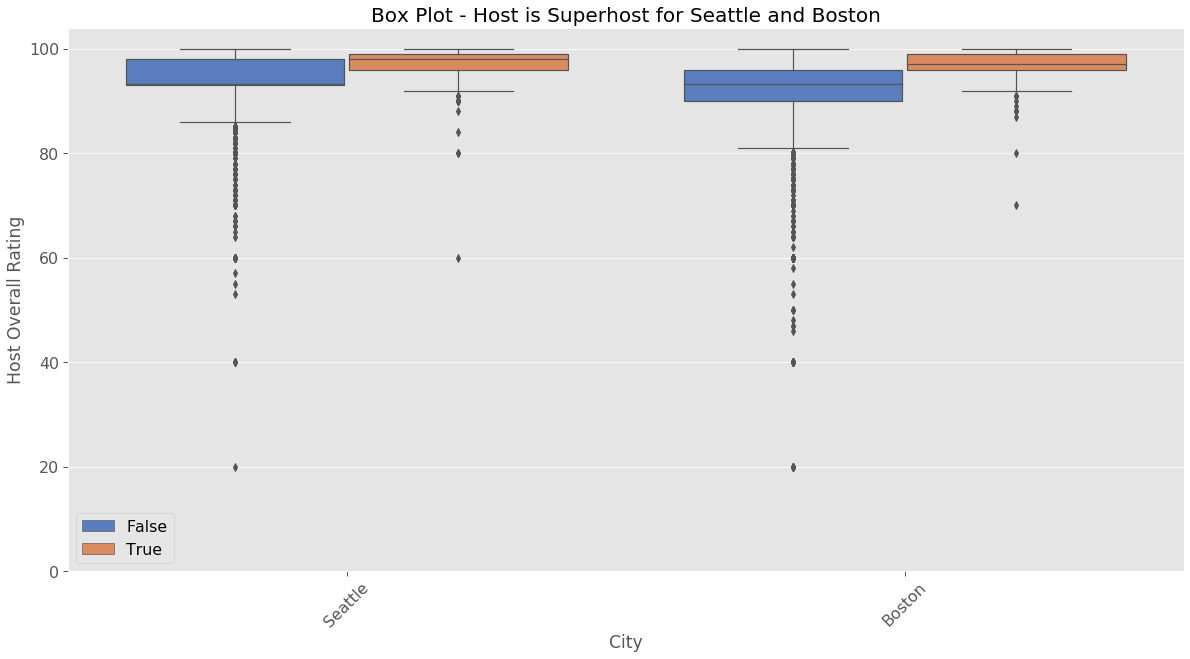

In [99]:
# create a box plot comparing host to superhost for review scores rating
plt.figure(figsize = [20, 10])
base_color = sns.color_palette()[0]
sns.set_context('paper', font_scale=1.8)
ax=sns.boxplot(data = air_listings, x = 'city', y = 'review_scores_rating', hue='host_is_superhost', palette='muted')
yticks =(0, 20,40, 60,80, 100)
ax.set_yticks(yticks)
plt.xticks(rotation = 45)
plt.title('Box Plot - Host is Superhost for Seattle and Boston', fontsize=20)
plt.ylabel('Host Overall Rating')
plt.xlabel('City')
ax.legend();

The boxplots reveal some interesting information about Superhosts and Host. While all hosts tend to have an overall rating that between 90 and 100%,  Superhost tend to have more of their data tightly clustered than Host.  The shaded areas of each boxplot represent 75% of their data (known as the Inter-Quartile Range.  We can assume from the chart that Superhosts tend to be more highly rated as a group by guests.

### Question 3 - How do the number of listings compare for Hosts and Suxperhosts?

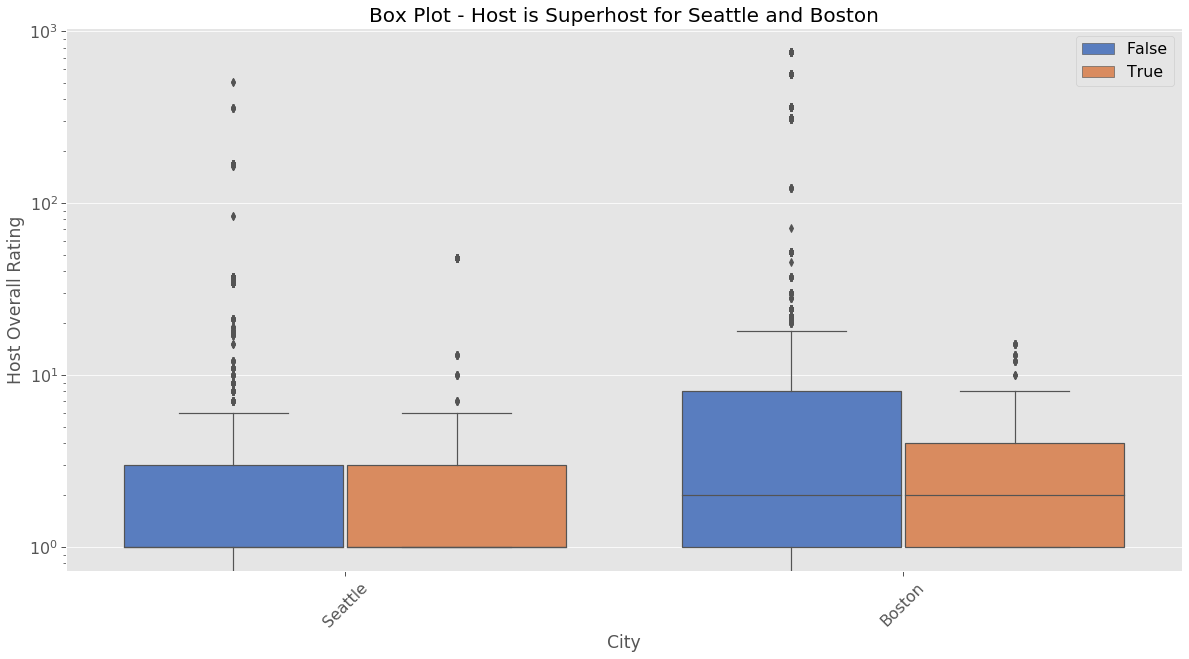

In [100]:
# create a box plot comparing the number of listings for hosts and superhosts in Seattle and Boston
plt.figure(figsize = [20, 10])
base_color = sns.color_palette()[0]
sns.set_context('paper', font_scale=1.8)
ax=sns.boxplot(data = air_listings, x = 'city', y = 'host_listings_count', hue='host_is_superhost', palette='muted')
plt.xticks(rotation = 45)
plt.title('Box Plot - Host is Superhost for Seattle and Boston', fontsize=20)
plt.ylabel('Host Overall Rating')
ax.set_yscale('log')
plt.xlabel('City')
ax.legend();

 ### Question 4 - How do number of reviews compare for Hosts and Superhosts?

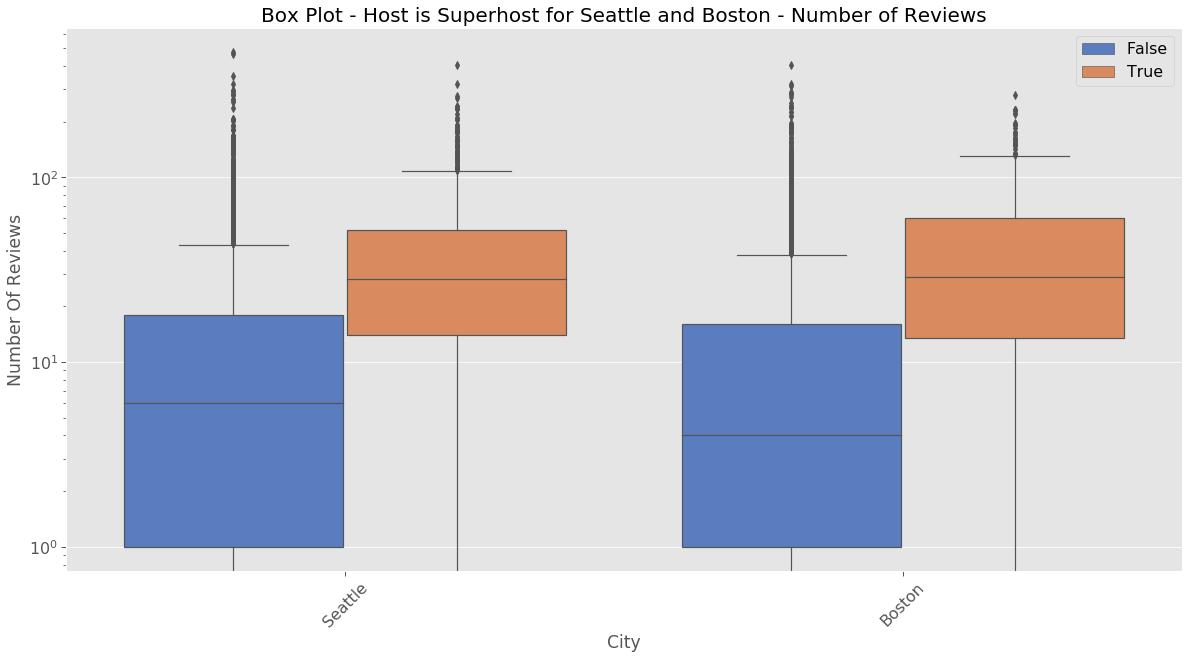

In [101]:
# create a box plot showing the distribution of reviews by host and superhost for Boston and Seattle
plt.figure(figsize = [20, 10])
base_color = sns.color_palette()[0]
sns.set_context('paper', font_scale=1.8)
ax=sns.boxplot(data = air_listings, x = 'city', y = 'number_of_reviews', hue='host_is_superhost', palette='muted')
plt.xticks(rotation = 45)
plt.title('Box Plot - Host is Superhost for Seattle and Boston - Number of Reviews', fontsize=20)
plt.ylabel('Number Of Reviews')
ax.set_yscale('log')
plt.xlabel('City')
ax.legend();

Although each of the boxplots have outliers, it is clear that the Superhosts tend to have higher reviews than Hosts.  If we assume the reviews are a result of customer stays, it appears that Superhosts will likely make additional revenue from stays compared to Hosts.

In [102]:
# This section plats a table showing the median and max counts of hosts that are superhosts in Seattle and Boston

air_listings.groupby(['host_is_superhost', 'city']).agg({'host_listings_count':['median', 'max']})


host_listings_count     
                                       median  max
host_is_superhost city                            
False             Boston                    2  749
                  Seattle                   1  502
True              Boston                    2   15
                  Seattle                   1   48

Looking at the boxplot and table above, Hosts appear to have a similar number of listings compared to superhosts, using median as the metric.  Notice that the boxplots are left skewed.  There are some outliers with a large number of listings, but, the median number  of listing (largest group) is similar.

It is clear from the statistic above that Superhosts have a higher mean acceptance rate that Hosts

### Question 5 - Are the superhosts grouped into different neighborhoods than hosts?

In [103]:
# this code filters the data used in the next two tables for Boston
superhost_neighbor_boston = air_listings.query('city=="Boston" & host_is_superhost == True')\
['neighbourhood_cleansed'].value_counts(normalize=True, ascending=False)[0:10]
host_neighbor_boston = air_listings.query('city=="Boston" & host_is_superhost == False')\
['neighbourhood_cleansed'].value_counts(normalize=True,ascending=False)[0:10]

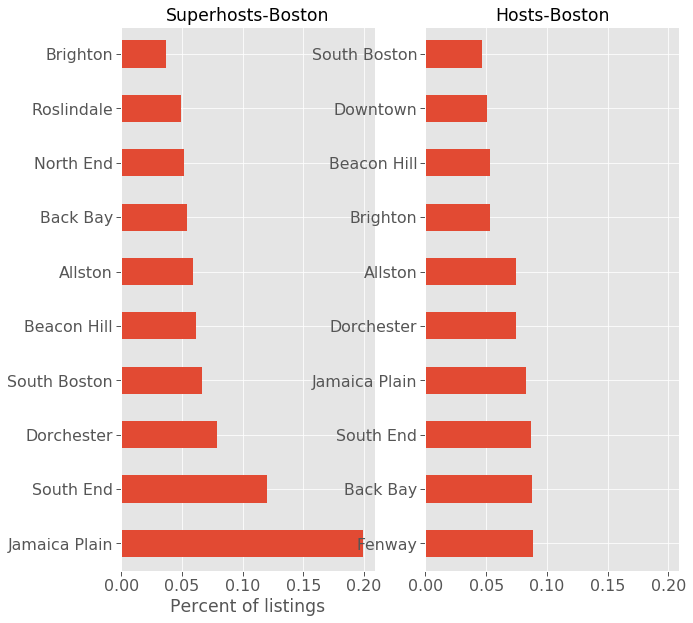

In [104]:
# This section plats a bare chart of the proportion of hosts that are superhosts in Seattle and Boston


plt.rcParams['font.size'] = 18

# This code creates the 1 row, 2 column matrix for the charts
fig,(ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True)


superhost_neighbor_boston.plot.barh(y = 'host_is_superhost', figsize=(10, 10), 
                                ax=ax0)
ax0.set_xlabel('Percent of listings')
ax0.set_ylabel('')
ax0.set_title("Superhosts-Boston")

host_neighbor_boston.plot.barh(y='host_is_superhost', figsize=(10, 10), 
                                ax=ax1)
ax1.set_ylabel('')
ax1.set_title("Hosts-Boston")


plt.show()



In [105]:
# this code filters the data used in the next two tables for Seattle
superhost_neighbor_seattle = air_listings.query('city=="Seattle" & host_is_superhost == True')\
['neighbourhood_cleansed'].value_counts(normalize=True, ascending=False)[0:10]
host_neighbor_seattle = air_listings.query('city=="Seattle" & host_is_superhost == False')\
['neighbourhood_cleansed'].value_counts(normalize=True, ascending=False)[0:10]

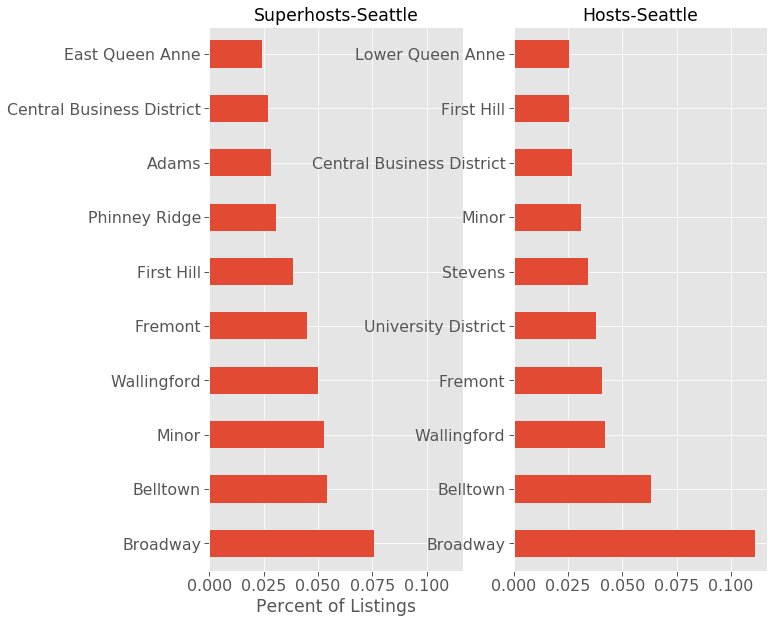

In [106]:
# This section plats side by side bar charts showing the percentage of listings by neighborhood for Seattle


plt.rcParams['font.size'] = 18
# This code creates the 1 row, 2 column matrix for the charts
fig,(ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True)


superhost_neighbor_seattle.plot.barh(figsize=(10, 10), 
                                ax=ax0)
ax0.set_xlabel('Percent of listings')
ax0.set_ylabel('')
ax0.set_xlabel('Percent of Listings')
ax0.set_title("Superhosts-Seattle")

host_neighbor_seattle.plot.barh(y='host_is_superhost', figsize=(10, 10), 
                                ax=ax1)
ax1.set_ylabel('')
ax1.set_title("Hosts-Seattle")


plt.show()

While Superhosts tend to be grouped in similary neighborhoods in Seattle, they are not grouped in similar neighborhoods in Boston. 

### Question 6 - How do the per day listing rates compare for Hosts and Superhosts?

In [107]:
# this code filters the data for host versus superhost, city and price
superhost_income_seattle = airbnb_data.query('city_y=="Seattle" & host_is_superhost == True & price_x > 0')['price_x']
host_income_seattle = airbnb_data.query('city_y=="Seattle" & host_is_superhost == False & price_x > 0')['price_x']
superhost_income_boston = airbnb_data.query('city_y=="Boston" & host_is_superhost == True & price_x > 0')['price_x']
host_income_boston = airbnb_data.query('city_y=="Boston" & host_is_superhost == False & price_x > 0')['price_x']

In [108]:
# this code creates a table showing median price and max price for hosts and superhosts in Boston and Seattle

round(airbnb_data.groupby(['host_is_superhost', 'city_x']).agg({'price_x':['median', 'max']}),2)

price_x        
                           median     max
host_is_superhost city_x                 
False             Boston    152.0  4000.0
                  Seattle   105.0  1650.0
True              Boston    150.0  7163.0
                  Seattle   110.0  1199.0

The median statistic was used in evaluating this question.  As seen in the table above, the there are some large per night values skewing the data.  Best choice is the median.  As such, it appears that the prices for Hosts and Superhosts are quite similar.   

### Save dataframes to .csv files

In [109]:
# save air_listings, air_calendar and air_ratings files to .csv file
air_listings.to_csv('air_listings.csv', index = False, encoding = 'utf-8')
air_calendar.to_csv('air_calendar.csv', index = False, encoding = 'utf-8')
air_reviews.to_csv('air_reviews.csv', index = False, encoding = 'utf-8')

## Model

### Question 6 - Can we use machine learning to predict who is a host or a superhost?

### Data Preparation for modeling

In [110]:
# Let's start by making a copy of the dataset
air_listing1 = air_listings.copy(deep=False)

In [111]:
# drop the following columns as they are not needed for the prediction study
air_listing1.drop(['listing_url', 'scrape_id','last_scraped', 'name','summary', 'space', 'description',
           'experiences_offered', 'neighborhood_overview', 'notes', 'transit',  'thumbnail_url', 'medium_url', 
           'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_since','host_location', 'host_about',
           'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'street', 
           'neighbourhood', 'neighbourhood_group_cleansed','neighbourhood_cleansed', 'state', 'amenities', 
           'smart_location', 'calendar_last_scraped', 'access','id', 'summary', 'country_code', 'country', 'city',               
           'latitude', 'longitude','host_id','host_since', 'is_location_exact', 'jurisdiction_names',
           'access', 'house_rules', 'calendar_updated', 'first_review', 'last_review'], axis=1, inplace=True)

In [112]:
# convert True and False to 1 and 0 for use in the machine learning model
var_list = ['has_availability', 'host_is_superhost', 'host_has_profile_pic', 'requires_license', 'instant_bookable',
           'require_guest_phone_verification', 'host_identity_verified', 'require_guest_profile_picture']

for var in var_list:
    air_listing1[var].replace(False, 0, inplace = True)
    air_listing1[var].replace(True, 1, inplace = True)

### Predicting Model

In [113]:
# create the explanatory and response variables
X=air_listing1.drop(['host_is_superhost', 'property_type', 'room_type', 'bed_type', 'cancellation_policy'], axis=1)
X = pd.get_dummies(X)

y = air_listing1['host_is_superhost']

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [114]:
# validate dummies creation was successful
X.columns.tolist()

['host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'requires_license',
 'instant_bookable',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'calculated_host_listings_count',
 'reviews_per_month',
 'Wireless Internet',
 'Heating',
 'Kitchen',
 'Essentials',
 'Smoke Detector',
 'Dryer',
 'Washer',
 'Internet',
 'TV',
 'Sham

In [115]:
# prepare the classifers to be used in KFold
clfs = [DecisionTreeClassifier(random_state=0), RandomForestClassifier(n_jobs=-1)]

nfolds = 10
kf = KFold(n_splits=nfolds,random_state=0,shuffle=True)

In [116]:
# Fit classifiers to get the best one
maxAUC = -1
bestCL = ""
for cl in clfs:
    auc = cross_val_score(cl,X,y,cv=kf,n_jobs=-1,scoring='roc_auc').mean()
    print (str(cl) + ' ' + str(auc))
    if auc > maxAUC:
        bestCL = cl
        maxAUC = auc
print('--------------------------------------------------------------------------------------------')
print ('Best classifier choice is ===>> ' + str(bestCL) + ' ' + str(maxAUC))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best') 0.7250281449288536
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False) 0.9301018744

In [117]:
# optimize the RandomForestClassifier using multiple parameters

parameters = {"max_depth": [2,4,6,8,10,12,None],
              "criterion": ('gini','entropy'),
              "min_samples_split" :[2,3,4,5,6],
              "min_samples_leaf": [1,2,3,4,5]
             }
            

rf_regr = RandomForestClassifier()
model = GridSearchCV(rf_regr,parameters, n_jobs = -1, cv = 10)
model_fit = model.fit(X_train,y_train)

learned_parameters = model_fit.best_params_ 

In [118]:
# check the accuracy of the chosen/optimized model
print("The optimized parameters are: :", learned_parameters)

y_pred2 = model_fit.predict(X_test)

print( "Model Training Accuracy is: ", accuracy_score(y_train, model_fit.predict(X_train)))
print( "Model Test Accuracy is: ", accuracy_score(y_test, y_pred2))

confusion_matrix(y_test, y_pred2)





The optimized parameters are: : {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Model Training Accuracy is:  1.0
Model Test Accuracy is:  0.9074949358541526


array([[1232,   20],
       [ 117,  112]], dtype=int64)

In [119]:
# training the model with the best parameters as a reference
rf = RandomForestClassifier(criterion= 'entropy',
                             max_depth= None,
                             min_samples_leaf= 2,
                             min_samples_split= 5,
                             random_state = 24)

print(rf.fit(X_train, y_train))
y_pred = rf.predict(X_test)

print("Train Accuracy is: ", accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy is: ", accuracy_score(y_test, y_pred))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=24, verbose=0,
                       warm_start=False)
Train Accuracy is:  0.9891928402566701
Test Accuracy is:  0.9041188386225524


In [120]:
# Check the importance of the features
pd.set_option('display.max_colwidth', 60)
feat = zip(X_train.columns,rf.feature_importances_)
important_features = pd.DataFrame(list(feat), columns =['feature','importance'])
print(important_features.sort_values(by=['importance'],ascending= False))

# save the important features to the important_features.csv file
important_features.to_csv('important_features.csv', index = False, encoding = 'utf-8')

                             feature  importance
25                 number_of_reviews    0.102854
26              review_scores_rating    0.095850
38                 reviews_per_month    0.060272
27            review_scores_accuracy    0.040155
28         review_scores_cleanliness    0.033168
11                             price    0.028488
4          host_total_listings_count    0.028384
19                    maximum_nights    0.027705
24                  availability_365    0.026979
3                host_listings_count    0.026160
37    calculated_host_listings_count    0.025962
32               review_scores_value    0.023085
2               host_acceptance_rate    0.022829
15                      cleaning_fee    0.022662
23                   availability_90    0.021463
22                   availability_60    0.020898
30       review_scores_communication    0.020617
14                  security_deposit    0.018323
21                   availability_30    0.017703
17                  

Of top items affecting the prediction of a Host as Superhost, 4 items were associtated with reviews (number of reviews, review scores rating, reviews per month, review scores communication) and 2 with ratings(overall host rating, review.  Price, reviews per month, availability, and the number of listings also were present in the top 10.

### Evaluation

This analysis successfully answered the following questions: 1) What are the proportions of Hosts and Superhosts for Seattle and Boston? 2) How does the Superhost compare to the Host for overall rating? 3) How do average overall stays compare for Superhosts and Hosts? 4) Are Superhosts clustered into different neighbourhoods than hosts? 5) How do the daily rates compare for hosts and superhosts? 6) Can we use machine learning to predict which Hosts will are Superhosts? 7) Using the data provided, what appears to be the most significant in predicting if a Host is a Superhost?  A summary of findings are found below:

* At 20%, there are twice as many superhosts in Seattle than there are in Boston.
* Using the calculated overall response rating, Superhosts tend to be more highly rated as a group by guests than Hosts.
* While Superhosts tend to be grouped in similary neighborhoods in Seattle, they are not grouped in similar neighborhoods in Boston.
* It appears that the daily listing prices for Hosts and Superhosts are quite similar.


Using RandomForest and DecisionTree classifiers, we were able to determine that RandomForest would provide the greatest accuracy.  After tuning the RandomForest Classifere was able to predict which hosts are superhosts using the available data with an accuracy of 90.4% 
